In [1]:
!pip install opendatasets --upgrade --quiet

In [2]:
import opendatasets as od

dataset_url = 'https://www.kaggle.com/jessicali9530/celeba-dataset'

od.download(dataset_url)

  0%|          | 0.00/1.33G [00:00<?, ?B/s]

100%|██████████| 1.33G/1.33G [00:31<00:00, 44.8MB/s]


In [3]:
import os 
from image_info import Image_info 
import numpy as np


DATA_DIR = 'celeba-dataset'
IMAGE_DIR = DATA_DIR+'/img_align_celeba/img_align_celeba'
total_images_in_dataset = len(os.listdir(IMAGE_DIR))
print("Total images : ",total_images_in_dataset)




Total images :  202599


Image Shape :  (218, 178, 3)
Number of channels :  3
Image height :  218
Image width :  178


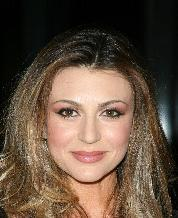

In [7]:
# getting a random image 

random_index = np.random.randint(0,total_images_in_dataset)
random_image_path = IMAGE_DIR+"/"+os.listdir(IMAGE_DIR)[random_index]

random_image = Image_info(random_image_path)
random_image.show_details()



In [8]:
  # making dataset and data loader with Data Augmentation and Normalization
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T


In [9]:
image_size = 64
batch_size = 128
stats = (0.5,0.5,0.5),(0.5,0.5,0.5) 

In [10]:
train_ds = ImageFolder(DATA_DIR, T.Compose([T.Resize(image_size),
                                                 T.CenterCrop(image_size),
                                                 T.ToTensor(),
                                                 T.Normalize(*stats)]))
train_loader = DataLoader(train_ds, batch_size,shuffle=True, num_workers=2,pin_memory=True)

In [11]:
#  helper functionto denormalize the normalized image ( for better visual only )
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline


In [12]:
def denorm(img_tensors):
  return img_tensors*stats[1][0] +stats[0][0]   # for each channel , adding the mean and multiplying by std

def show_images(images, nmax = 64):


    fig , ax = plt.subplots(figsize= (8,8))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]),nrow=8).permute(1,2,0))


def show_batch(dl , nmax = 64):
  for images , _ in dl : 
    show_images(images, nmax)
    break



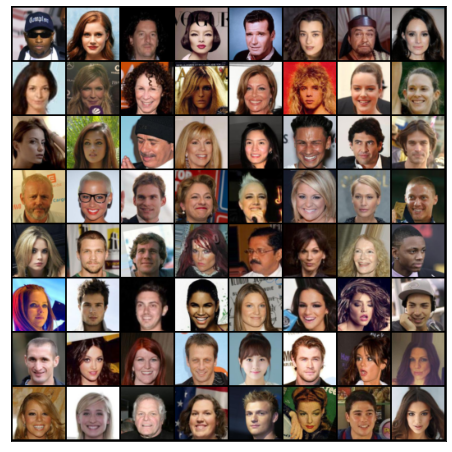

In [13]:
show_batch(train_loader)

## Using GPU

In [14]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [15]:
device = get_default_device()
device

device(type='cuda')

In [16]:
train_dl = DeviceDataLoader(train_loader,device)

In [17]:
# creatin a neural network named discriminator which can discriminate between real image or fake image . 

import torch.nn as nn

discriminator = nn.Sequential(
    

    # 3 x 64 x 64
    nn.Conv2d(3,64,kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2,inplace=True),

    # 64 x 32 x 32
    nn.Conv2d(64,128,kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2,inplace=True),

    # 128 x 16 x 16
    nn.Conv2d(128,256,kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2,inplace=True),

    # 256 x 8 x 8
    nn.Conv2d(256,512,kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2,inplace=True),

    # 512 x 4 x 4 
    nn.Conv2d(512,1, kernel_size=4, stride=1, padding=0 , bias=False),

    # 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid()


)



In [18]:
discriminator = to_device(discriminator, device)


In [19]:
# Generator Network 

latent_size = 128

In [21]:
generator = nn.Sequential(
    
    # latent_size x 1 x 1
    nn.ConvTranspose2d(latent_size, 512, kernel_size=4,stride=1,padding=0, bias = False),
    nn.BatchNorm2d(512),
    nn.ReLU(),

    # 512 x 4 x 4

    nn.ConvTranspose2d(512,256 , kernel_size=4 , stride=2, padding=1, bias =False),
    nn.BatchNorm2d(256),
    nn.ReLU(),

    # 256 x 8 x 8 
    nn.ConvTranspose2d(256,128, kernel_size=4, stride=2, padding = 1, bias = False),
    nn.BatchNorm2d(128),
    nn.ReLU(),

    # 128 x 16 x 16
    nn.ConvTranspose2d(128,64, kernel_size=4, stride=2, padding = 1, bias = False),
    nn.BatchNorm2d(64),
    nn.ReLU(),

    # 64 x 32 x 32
    nn.ConvTranspose2d(64,3, kernel_size=4, stride=2, padding = 1, bias = False),
    nn.Tanh()  #  to have the output in range (-1,1) just like normalized value

    # 3 x 64 x 64


)

xb.shape:  torch.Size([128, 128, 1, 1])
fake_images.shape :  torch.Size([128, 3, 64, 64])
each fake image shape :  torch.Size([3, 64, 64])


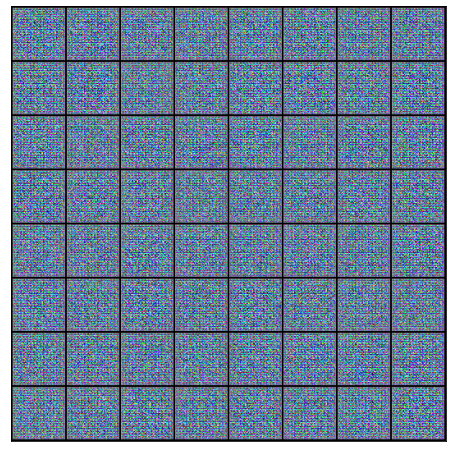

In [22]:
# generating image 
xb = torch.randn(batch_size, latent_size,1,1 , device = device)
print("xb.shape: ",xb.shape)
fake_images = generator(xb.cpu())
print("fake_images.shape : ", fake_images.shape)
print("each fake image shape : " , fake_images[0].shape)
show_images(fake_images.cpu())

In [23]:
# taking the generator to device
generator = to_device(generator,device)

## Training 

###  Discriminator Training 

In [24]:
def train_discriminator(real_images, opt_d):
  # clearing discriminator gradients
  opt_d.zero_grad()

  # passing real image to the discriminatior
  real_preds = discriminator(real_images)
  real_targets = torch.ones(real_images.size(0),1,device = device)
  real_loss = F.binary_cross_entropy(real_preds, real_targets)
  real_score = torch.mean(real_preds).item()


  # generate fake image 

  latent = torch.randn(batch_size, latent_size, 1,1, device = device)
  fake_images = generator(latent)


  # passing fake image to the discriminator

  fake_preds = discriminator(fake_images)
  fake_targets = torch.zeros(fake_images.size(0), 1, device = device)
  fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
  fake_score = torch.mean(fake_preds).item()


  # update the loss

  loss = real_loss + fake_loss
  loss.backward()
  opt_d.step()

  return loss.item() , real_score, fake_score



### Generator Training

In [25]:
def train_generator(opt_g):

  # clearing opt_g gradients 

  opt_g.zero_grad()

  # generate fake image

  latent = torch.randn(batch_size, latent_size, 1,1, device=device)
  fake_images = generator(latent)

  # try to fool the discriminator 
  
  preds = discriminator(fake_images)
  targets = torch.ones(batch_size,1, device = device)   # fake_images.size(0) == batch_size
  loss = F.binary_cross_entropy(preds, targets)

  # update the generator with weights 

  loss.backward()
  opt_g.step()

  return loss.item()


## saving sample images in directory

In [26]:
from torchvision.utils import save_image

In [27]:
sample_dir = "generated"
#make directory 
os.makedirs(sample_dir, exist_ok=True)




In [28]:
# defining a function for saving the output batch images 

def save_samples(index, latent_tensor, show = True):
  fake_images = generator(latent_tensor)
  fake_name = 'generated-images-{0:0=4d}.png'.format(index)
  save_image(denorm(fake_images),os.path.join(sample_dir,fake_name),nrow = 8)
  print("Saving ",fake_name)
  if show: 
    fig , ax = plt.subplots(figsize = (8,8))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(fake_images.cpu().detach(), nrow = 8).permute(1,2,0))


In [29]:
fixed_latent = torch.randn(64,latent_size,1,1,device=device) # fixing one latent tensor so that we can see the evolution on it as out model learns to generate 



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving  generated-images-0000.png


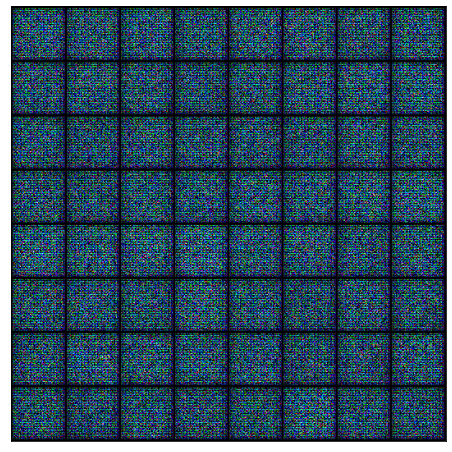

In [30]:
save_samples(0,fixed_latent)

# Main Fit Function

In [31]:
from tqdm.notebook import tqdm
import torch.nn.functional as F


In [32]:
def fit(epochs, lr, start_idx = 1):

  # setting free gpu 
  torch.cuda.empty_cache()

  # losses and scores

  losses_g = []
  losses_d = []
  real_scores = []
  fake_scores = []

  # create optimizers 

  opt_d = torch.optim.Adam(discriminator.parameters(),lr = lr , betas = (0.5, 0.999))
  opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

  for epoch in range(epochs):
    for real_images, _ in tqdm(train_dl):
      # train discriminator 
      loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
      
      # train generator 
      loss_g = train_generator(opt_g)
    

    losses_g.append(loss_g)
    losses_d.append(loss_d)
    real_scores.append(real_score)
    fake_scores.append(fake_score)

    # log losses and scores 

    print("Epoch[{}/{}] , loss_g : {:.4f} , loss_d : {:.4f} , real_score : {:.4f} , fake_score : {:.4f}".format(epoch+1,epochs,loss_g,loss_d,real_score,fake_score))


    # save generated image 

    save_samples(epoch+start_idx,fixed_latent,show=False)  

  return losses_g, losses_d , real_scores , fake_scores




In [33]:
lr = 0.002
epochs = 20

In [ ]:
history = fit(epochs=epochs,lr = lr)


Epoch[1/20] , loss_g : 2.0530 , loss_d : 0.8989 , real_score : 0.6213 , fake_score : 0.2250
Saving  generated-images-0001.png



Epoch[2/20] , loss_g : 2.8390 , loss_d : 0.3542 , real_score : 0.7966 , fake_score : 0.0866
Saving  generated-images-0002.png



Epoch[3/20] , loss_g : 1.5833 , loss_d : 0.6922 , real_score : 0.6479 , fake_score : 0.1532
Saving  generated-images-0003.png



Epoch[4/20] , loss_g : 1.2455 , loss_d : 0.7319 , real_score : 0.6309 , fake_score : 0.1549
Saving  generated-images-0004.png



Epoch[5/20] , loss_g : 3.6013 , loss_d : 0.6624 , real_score : 0.8027 , fake_score : 0.2910
Saving  generated-images-0005.png



Epoch[6/20] , loss_g : 2.1628 , loss_d : 0.5794 , real_score : 0.7529 , fake_score : 0.1794
Saving  generated-images-0006.png



Epoch[7/20] , loss_g : 5.4451 , loss_d : 8.5106 , real_score : 0.0014 , fake_score : 0.0000
Saving  generated-images-0007.png



Epoch[8/20] , loss_g : 2.6934 , loss_d : 0.6251 , real_score : 0.7445 , fake_score : 0.1989
Saving  generated-images-0008.png



Epoch[9/20] , loss_g : 54.7185 , loss_d : 0.0000 , real_score : 1.0000 , fake_score : 0.0000
Saving  generated-images-0009.png



Epoch[10/20] , loss_g : 54.4054 , loss_d : 0.0000 , real_score : 1.0000 , fake_score : 0.0000
Saving  generated-images-0010.png



Epoch[11/20] , loss_g : 0.9654 , loss_d : 1.1950 , real_score : 0.4477 , fake_score : 0.2221
Saving  generated-images-0011.png



Epoch[12/20] , loss_g : 3.1015 , loss_d : 0.4655 , real_score : 0.8762 , fake_score : 0.2469
Saving  generated-images-0012.png



Epoch[13/20] , loss_g : 0.8299 , loss_d : 2.0142 , real_score : 0.1998 , fake_score : 0.0053
Saving  generated-images-0013.png



Epoch[14/20] , loss_g : 7.3421 , loss_d : 0.2414 , real_score : 0.8251 , fake_score : 0.0004
Saving  generated-images-0014.png


In [ ]:
losses_g, losses_d, real_scores, fake_scores = history

In [ ]:
# Save the model checkpoints 
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

In [ ]:
sample_dir

In [ ]:
os.listdir(sample_dir)[0]

In [ ]:
os.path.join(sample_dir,os.listdir(sample_dir)[0])

In [ ]:
def sample_names(index):
  return os.path.join(sample_dir,os.listdir(sample_dir)[index])

### Displaying Some image 

In [ ]:
from IPython.display import Image

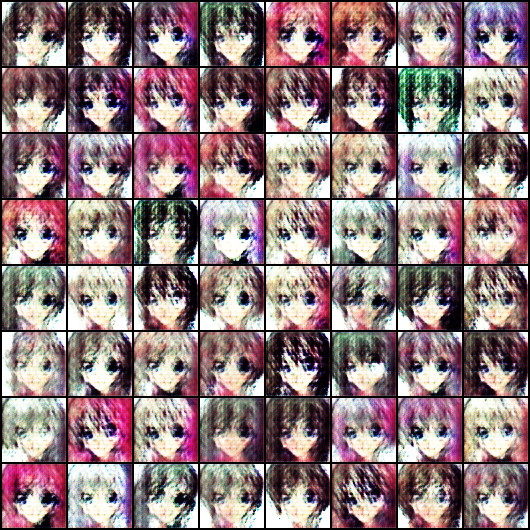

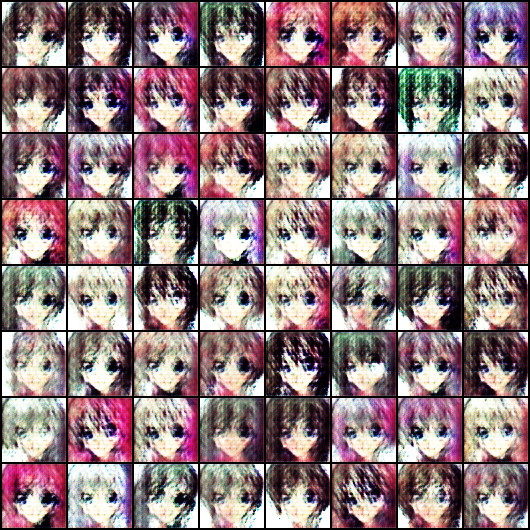

In [ ]:
Image(sample_names(0))

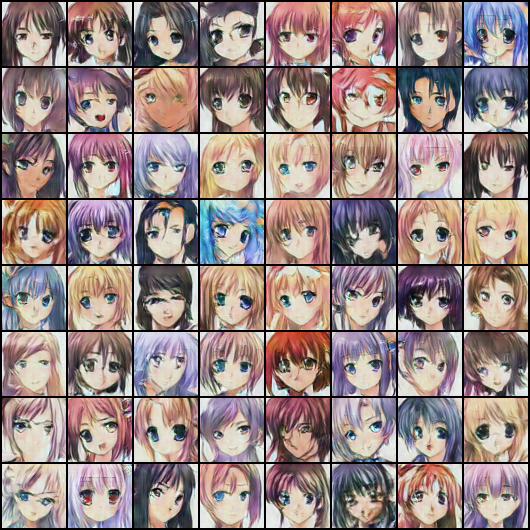

In [ ]:
Image(sample_names(10)) # fake_score : 0.0842

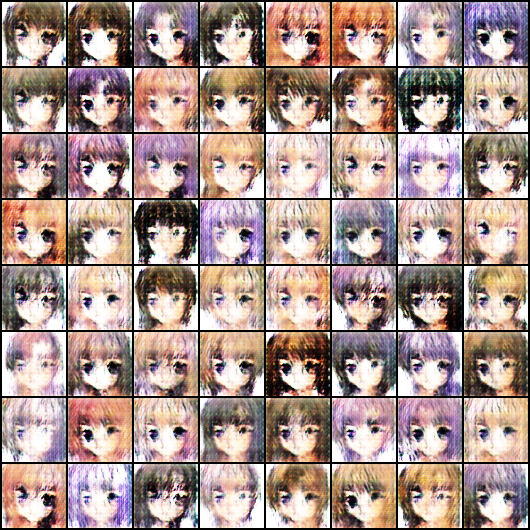

In [ ]:
Image(sample_names(15))

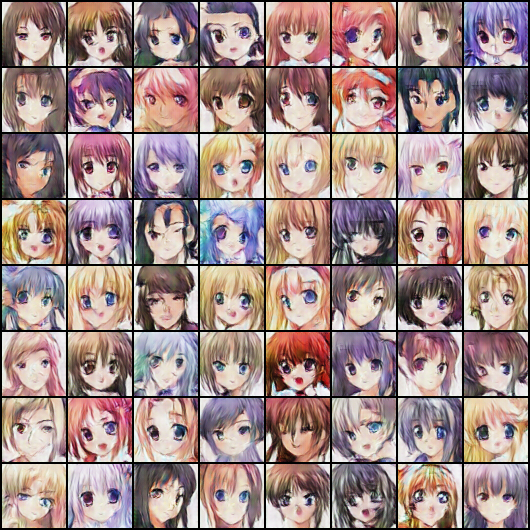

In [ ]:
Image(sample_names(-2)) # fake_score : 0.0023

In [ ]:
import cv2
import os

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

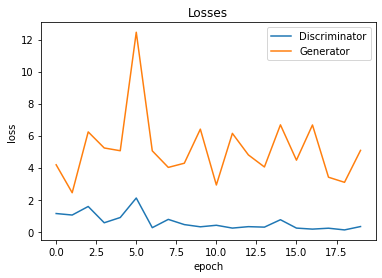

In [ ]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

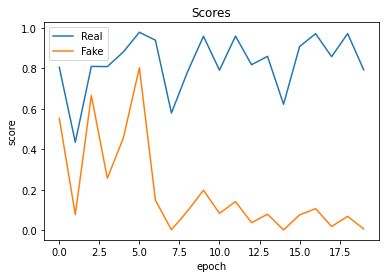

In [ ]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');